In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
%ls

2_week-4-ridge-regression-assignment-1-blank.ipynb
Assig_1_Seattle_housing_regression.ipynb
Lasso_Neural_WU-Target divided by 1000.ipynb
Lasso_Neural_WU.ipynb
Lasso_preferred.ipynb
Lasso_preferred_work.ipynb
Matrix Week 2 assignment.ipynb
Overfitting_Demo_Ridge_Lasso.ipynb
Overfitting_Demo_Ridge_Lasso.ipynb copy*
Week 2 assignmnet.ipynb
copy2_week-2-multiple-regression-assignment-1-blank.ipynb
extra_week-1-simple-regression-assignment-blank.ipynb
extra_week-2-multiple-regression-assignment-2-blank.ipynb
house_set_1_data.csv
house_set_2_data.csv
house_set_4_data.csv
house_test_data.csv*
house_train_data.csv*
house_valid_data.csv*
kc_house_data.csv*
kc_house_set_3_data.csv
week-3-polynomial-regression-assignment-blank.ipynb
week-4-ridge-regression-assignment-1-blank.ipynb
week-4-ridge-regression-assignment-2-blank.ipynb
week-5-lasso-assignment-1-blank.ipynb
week-5-lasso-assignment-2-blank.ipynb
week-6-local-regression-assignment-blank.ipynb


In [49]:
train = pd.read_csv('house_train_data.csv')
train.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000


###### Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
###### On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

In [50]:
from math import log, sqrt
train['sqft_living_sqrt'] = train['sqft_living'].apply(sqrt)
train['sqft_lot_sqrt'] = train['sqft_lot'].apply(sqrt)
train['bedrooms_square'] = train['bedrooms']*train['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
train['floors'] = train['floors'].astype(float) 
train['floors_square'] = train['floors']*train['floors']

In [51]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

In [52]:
# Training Set
X_train = train.loc[:, all_features]
y_train = train.loc[:, 'price']

###### Validation

In [53]:
val = pd.read_csv('house_valid_data.csv')
val.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650


In [54]:
#New Features for Validation set
from math import log, sqrt
val['sqft_living_sqrt'] = val['sqft_living'].apply(sqrt)
val['sqft_lot_sqrt'] = val['sqft_lot'].apply(sqrt)
val['bedrooms_square'] = val['bedrooms']*val['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
val['floors'] = val['floors'].astype(float) 
val['floors_square'] = val['floors']*val['floors']

In [55]:
# Test Set
X_test = val.loc[:, all_features]
y_test = val.loc[:, 'price']

In [56]:
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (9761, 17)
X_test : (9635, 17)
y_train : (9761,)
y_test : (9635,)


##### Use loc to standardize the data without losing the column names

In [57]:
from sklearn.preprocessing import StandardScaler
# Standardize numerical features
stdSc = StandardScaler()
"""X_train = stdSc.fit_transform(X_train)
X_test = stdSc.transform(X_test)"""
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, all_features] = stdSc.fit_transform(X_train.loc[:, all_features])
X_test.loc[:, all_features] = stdSc.transform(X_test.loc[:, all_features])

##### Log Transform the Target

In [58]:
#Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.
# Log transform the target for official scoring
y_train = y_train/1_000
y_test = y_test/1_000

##### RMSE

In [59]:
#Cross Validation Score: RMSE

# Define error measure for official scoring : RMSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Training RMSE : 211.556317604
Test RMSE : 202.782484325


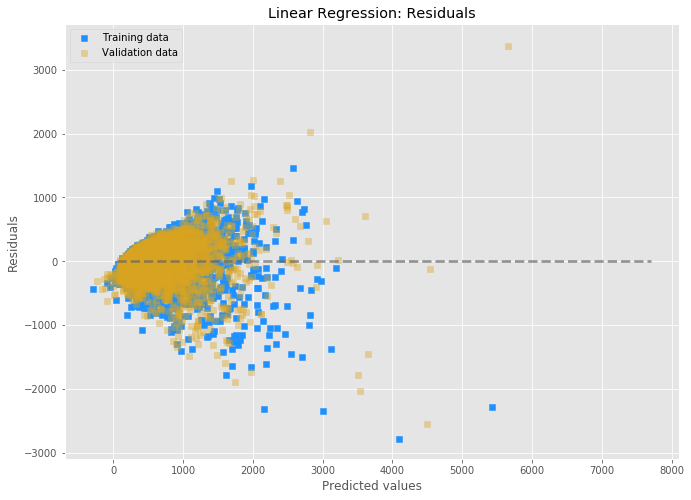

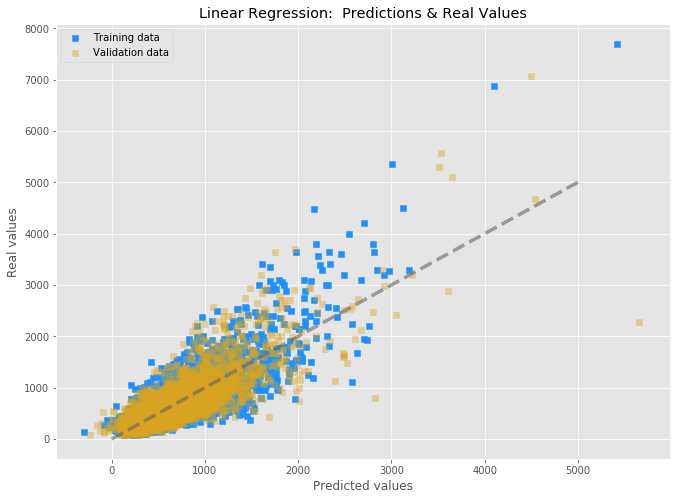

In [68]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("Training RMSE :", rmse_cv_train(lr).mean())
print("Test RMSE :", rmse_cv_test(lr).mean())
lrTr = rmse_cv_train(lr).mean()
lrTs = rmse_cv_test(lr).mean()
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.figure(figsize=(11,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.4)
plt.title("Linear Regression: Residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(y_train) - 25, xmax = max(y_train), color = "#666666", linestyle = "dashed", linewidth = 2.5, alpha = 0.7)
plt.show()

# Plot predictions
plt.figure(figsize=(11,8))
plt.scatter(y_train_pred, y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.4)
plt.title("Linear Regression:  Predictions & Real Values")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 5000], [0,5000], c = "#666666", linestyle = "dashed", linewidth = 3.5, alpha = 0.6)
plt.show()

##### Create Coefficient Matrix

In [69]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + [i for i in all_features]
ind = ["linear", "lasso", "elasticNet"]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
models = ["linear", "lasso", "elasticNet"]

#Return the result in pre-defined format
rss = sum((y_train_pred-y_train)**2)
ret = [rss]
ret.extend([lr.intercept_])
ret.extend(lr.coef_)

for i, j in enumerate(ret):
    coef_matrix_simple.iloc[0, i] = j

In [71]:
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,420637935.962,542.735,-14.994,6.300,42.972,332.491,-507.564,43.203,-60.731,-39.423,45.935,57.511,28.782,18.078,154.057,288.805,151.171,-96.478,5.157
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Lasso Regression

In [27]:
l1_penalty_values = np.logspace(1, 7, num=13)
l1_penalty_values

array([  1.00000000e+01,   3.16227766e+01,   1.00000000e+02,
         3.16227766e+02,   1.00000000e+03,   3.16227766e+03,
         1.00000000e+04,   3.16227766e+04,   1.00000000e+05,
         3.16227766e+05,   1.00000000e+06,   3.16227766e+06,
         1.00000000e+07])

Best alpha : 1.0


/Users/jimdoone/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso RMSE on Training set : 211.846982568
Lasso RMSE on Test set : 202.806865478


/Users/jimdoone/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


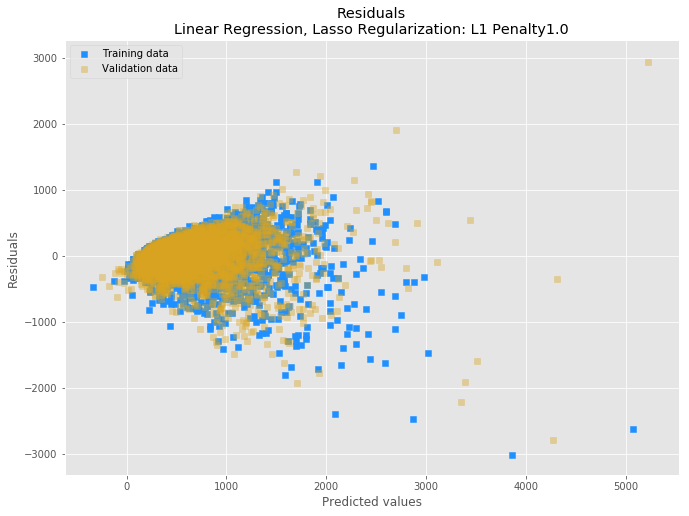

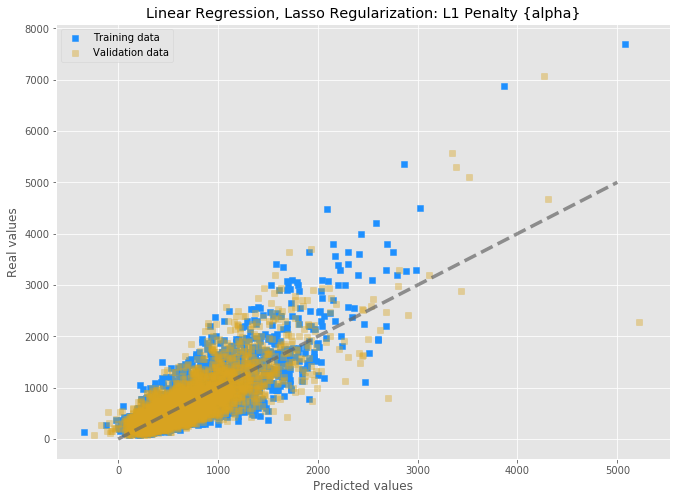

Lasso picked 14 features and eliminated the other 3 features


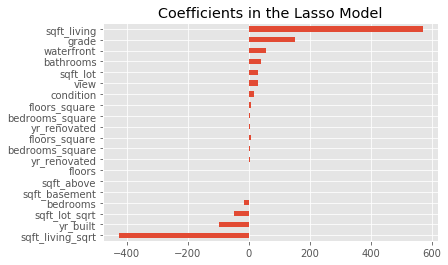

In [72]:

# 3* Lasso
lasso = LassoCV(alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 60.0, 100.0], 
                max_iter = 100_000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)



print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
lsTr = rmse_cv_train(lasso).mean()
lsTs = rmse_cv_test(lasso).mean()
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.figure(figsize=(11, 8))
plt.scatter(y_train_las, y_train_las - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.4)
plt.title(f"Residuals\nLinear Regression, Lasso Regularization: L1 Penalty{alpha}")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 16.5, color = "#666666", linestyle = 'dashed', alpha = 0.7, linewidth = 3.5)
plt.show()

# Plot predictions
plt.figure(figsize=(11, 8))
plt.scatter(y_train_las, y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.4)
plt.title("Linear Regression, Lasso Regularization: L1 Penalty {alpha}")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 5000], [0, 5000], c = "#666666", linestyle = 'dashed', alpha = 0.7, linewidth = 3.5)
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [73]:
#Return the result in pre-defined format
rss = sum((y_train_las-y_train)**2)
retL = [rss]
retL.extend([lasso.intercept_])
retL.extend(lasso.coef_)



for i, j in enumerate(retL):
    coef_matrix_simple.iloc[1, i] = j
    
    
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,420637935.962,542.735,-14.994,6.300,42.972,332.491,-507.564,43.203,-60.731,-39.423,45.935,57.511,28.782,18.078,154.057,288.805,151.171,-96.478,5.157
lasso,422943305.631,542.735,-15.515,4.775,39.310,571.812,-426.478,32.293,-48.847,-0.000,8.908,56.530,29.982,16.235,152.198,0.000,0.000,-96.313,4.064
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Best l1_ratio : 1.0
Best alpha : 0.6
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.7
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.7
Best l1_ratio : 1.0
Best alpha : 0.63
ElasticNet RMSE on Training set : 209.345154292
ElasticNet RMSE on Test set : 202.963122765


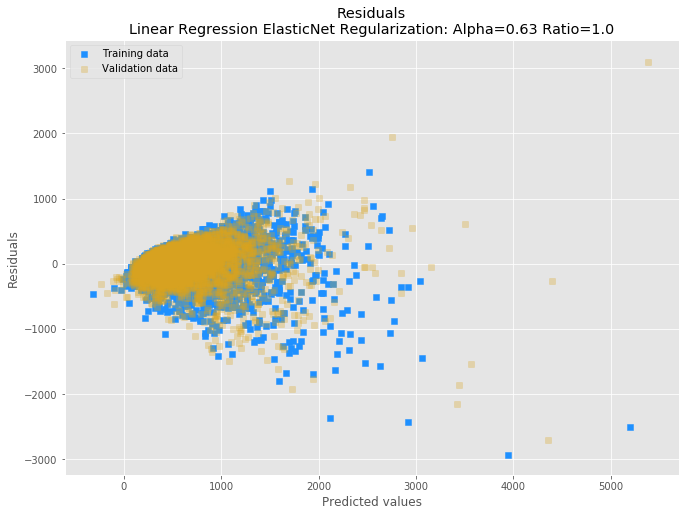

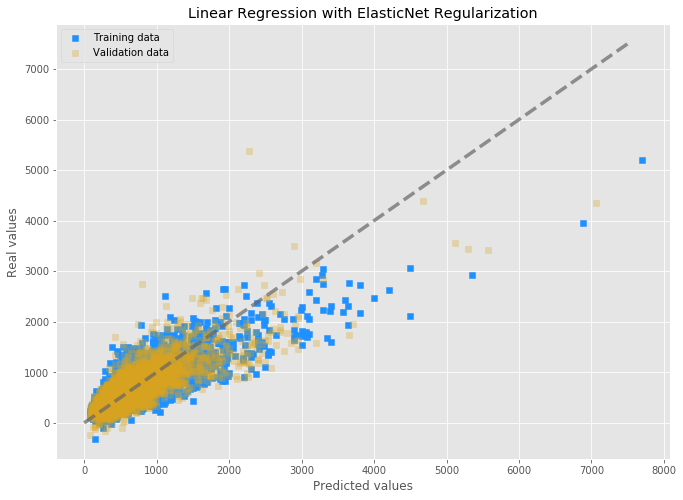

ElasticNet picked 15 features and eliminated the other 2 features


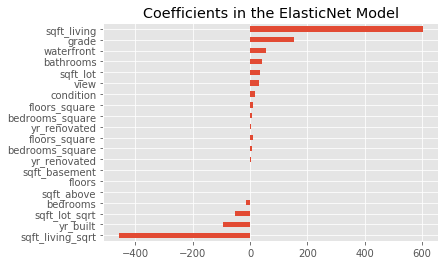

In [74]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 
                                    1.0, 3.0, 6.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.6, 2.2, 2.4, 2.8, 8.0, 9.0, 13.0, 14.0, 17.0], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.figure(figsize=(11,8))
plt.scatter(y_train_ela, y_train_ela - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.3)
plt.title(f"Residuals\nLinear Regression ElasticNet Regularization: Alpha={alpha} Ratio={ratio}")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 16.5, color = "#666666", linestyle = 'dashed', alpha = 0.7, linewidth = 3.5)
plt.show()

# Plot predictions
plt.figure(figsize=(11,8))
plt.scatter(y_train, y_train_ela, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.3)
plt.title("Linear Regression with ElasticNet Regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 7500], [0, 7500], c = "#666666", linestyle = 'dashed', alpha = 0.7, linewidth = 3.5)
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [75]:
models = ["linear", "lasso", "elasticNet"]


    
#Return the result in pre-defined format
rss = sum((y_train_ela-y_train)**2)
retE = [rss]
retE.extend([elasticNet.intercept_])
retE.extend(elasticNet.coef_)



for i, j in enumerate(retE):
    coef_matrix_simple.iloc[2, i] = j
    
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,420637935.962,542.735,-14.994,6.300,42.972,332.491,-507.564,43.203,-60.731,-39.423,45.935,57.511,28.782,18.078,154.057,288.805,151.171,-96.478,5.157
lasso,422943305.631,542.735,-15.515,4.775,39.310,571.812,-426.478,32.293,-48.847,-0.000,8.908,56.530,29.982,16.235,152.198,0.000,0.000,-96.313,4.064
elasticNet,421753727.511,542.735,-15.322,5.348,40.409,603.250,-459.100,36.176,-52.995,-0.000,8.821,56.860,29.643,17.081,152.953,0.000,0.052,-96.109,4.465


In [76]:
#lrTr = rmse_cv_train(lr).mean()
#lsTr = rmse_cv_train(lasso).mean()
enTr = rmse_cv_train(elasticNet).mean()

#lrTs = rmse_cv_test(lr).mean()
#lsTs = rmse_cv_test(lasso).mean()
enTs = rmse_cv_test(elasticNet).mean()



In [77]:
print(f"Training RMSE :{lrTr:.4f}")
print(f"Lasso RMSE on Training set :{lsTr:.4f}")
print(f"ElasticNet RMSE on Training set :{enTr:.4f}")
print("*****" * 10)
print(f"Test RMSE :{lrTs:.4f}")
print(f"Lasso RMSE on Test set :{lsTs:.4f}")
print(f"ElasticNet RMSE on Test set :{enTs:.4f}") 


Training RMSE :211.5563
Lasso RMSE on Training set :211.8470
ElasticNet RMSE on Training set :209.3452
**************************************************
Test RMSE :202.7825
Lasso RMSE on Test set :202.8069
ElasticNet RMSE on Test set :202.9631


In [78]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.preprocessing import text
from keras.preprocessing import text
model = Sequential()



In [79]:
# In this case, the number of variables in the inner layer is 11
# And the number of variable in the outer layer is 1
# 11 + 1 / 2 = 6 --> units = 6
# The Add function adds the hidden layer 
model.add(Dense(units = 10, kernel_initializer='normal', activation ='relu', input_dim =17))
model.add(Dense(units = 7, kernel_initializer='normal', activation ='relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 5, kernel_initializer='normal', activation ='relu'))
model.add(Dense(units = 1, kernel_initializer='normal'))

model.compile(optimizer='adam', loss = 'mae', metrics =['mae'])
model.fit(X_train.values, y_train.values, epochs = 200, verbose=1)
score = model.evaluate(X_train.values, y_train.values, verbose=0)

Epoch 1/200
9761/9761 [==============================] - 1s - loss: 528.1733 - mean_absolute_error: 528.1733     
Epoch 2/200
9761/9761 [==============================] - 1s - loss: 296.0668 - mean_absolute_error: 296.0668     
Epoch 3/200
9761/9761 [==============================] - 1s - loss: 211.6555 - mean_absolute_error: 211.6555     
Epoch 4/200
9761/9761 [==============================] - 1s - loss: 192.4768 - mean_absolute_error: 192.4768     
Epoch 5/200
9761/9761 [==============================] - 1s - loss: 180.6294 - mean_absolute_error: 180.6294     
Epoch 6/200
9761/9761 [==============================] - 1s - loss: 170.7088 - mean_absolute_error: 170.7088     
Epoch 7/200
9761/9761 [==============================] - 1s - loss: 164.1941 - mean_absolute_error: 164.1941     
Epoch 8/200
9761/9761 [==============================] - 1s - loss: 159.0595 - mean_absolute_error: 159.0595     - ETA: 1s - loss: 152.6946 - mea
Epoch 9/200
9761/9761 [==============================] -

9761/9761 [==============================] - 1s - loss: 145.5047 - mean_absolute_error: 145.5047     
Epoch 73/200
9761/9761 [==============================] - 1s - loss: 146.5460 - mean_absolute_error: 146.5460     
Epoch 74/200
9761/9761 [==============================] - 1s - loss: 146.7108 - mean_absolute_error: 146.7108     
Epoch 75/200
9761/9761 [==============================] - 1s - loss: 147.2854 - mean_absolute_error: 147.2854     
Epoch 76/200
9761/9761 [==============================] - 1s - loss: 146.2438 - mean_absolute_error: 146.2438     
Epoch 77/200
9761/9761 [==============================] - 1s - loss: 144.4425 - mean_absolute_error: 144.4425     
Epoch 78/200
9761/9761 [==============================] - 1s - loss: 145.5991 - mean_absolute_error: 145.5991     
Epoch 79/200
9761/9761 [==============================] - 1s - loss: 144.4102 - mean_absolute_error: 144.4102     
Epoch 80/200
9761/9761 [==============================] - 1s - loss: 145.0271 - mean_absolute

9761/9761 [==============================] - 1s - loss: 138.6505 - mean_absolute_error: 138.6505     
Epoch 143/200
9761/9761 [==============================] - 1s - loss: 137.1708 - mean_absolute_error: 137.1708     
Epoch 144/200
9761/9761 [==============================] - 1s - loss: 138.8207 - mean_absolute_error: 138.8207     
Epoch 145/200
9761/9761 [==============================] - 1s - loss: 139.5808 - mean_absolute_error: 139.5808     
Epoch 146/200
9761/9761 [==============================] - 1s - loss: 138.4619 - mean_absolute_error: 138.4619     
Epoch 147/200
9761/9761 [==============================] - 1s - loss: 136.9667 - mean_absolute_error: 136.9667     
Epoch 148/200
9761/9761 [==============================] - 1s - loss: 136.4223 - mean_absolute_error: 136.4223     
Epoch 149/200
9761/9761 [==============================] - 1s - loss: 138.4492 - mean_absolute_error: 138.4492     
Epoch 150/200
9761/9761 [==============================] - 1s - loss: 137.2337 - mean_

In [80]:
score

[124.71768991044158, 124.71768991044158]

In [83]:
x = score[0] * 1000
print(f"{x:,.0f}")

124,718


In [86]:
ypred_test =  model.predict(X_test.values)
ypred_train = model.predict(X_train.values)


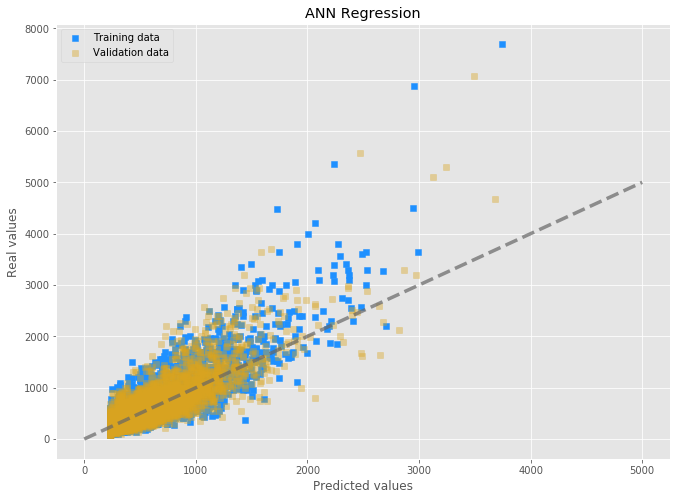

In [87]:
# Plot predictions
plt.figure(figsize=(11, 8))
plt.scatter(ypred_train, y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(ypred_test, y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.4)
plt.title("ANN Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 5000], [0, 5000], c = "#666666", linestyle = 'dashed', alpha = 0.7, linewidth = 3.5)
plt.show()

